In [1]:
# this cell loads all files necessary for fitting a vanilla DDM (sometimes called the pure DDM)

using DriftDiffusionModels
using Plots
using Random
using Turing

In [2]:
# this cell will simulate a DDM process so we have data we can fit later on, we will later fit to other data that is not simulated
B = 2.0       # bound height
v = 0.73      # drift rate
a₀ = 0.62     # initial starting point (as fraction of bound)
τ = 0.2       # non-decision time (s)

ddm_results = simulateDDM(DriftDiffusionModel(B, v, a₀, τ), 500, 1e-6) # simulate 500 trials with very small dt

500-element Vector{DDMResult}:
 DDMResult(1.7046179999499516, 1, 1)
 DDMResult(0.44009799999514315, 1, 1)
 DDMResult(0.9544040000066071, -1, -1)
 DDMResult(0.42940199999542933, 1, 1)
 DDMResult(0.6802959999987249, 1, 1)
 DDMResult(0.5001189999935438, 1, 1)
 DDMResult(1.1230079999977987, 1, 1)
 DDMResult(1.2672439999859328, 1, -1)
 DDMResult(0.7584240000009715, 1, 1)
 DDMResult(0.2973749999989618, 1, 1)
 ⋮
 DDMResult(0.8131650000025457, 1, 1)
 DDMResult(0.4386539999951818, 1, 1)
 DDMResult(1.1554159999951326, -1, -1)
 DDMResult(0.45368699999477957, 1, 1)
 DDMResult(0.2981359999989414, 1, 1)
 DDMResult(0.8186450000027032, -1, -1)
 DDMResult(0.8011880000022013, -1, -1)
 DDMResult(1.452479999970694, 1, 1)
 DDMResult(0.4285509999954521, 1, 1)

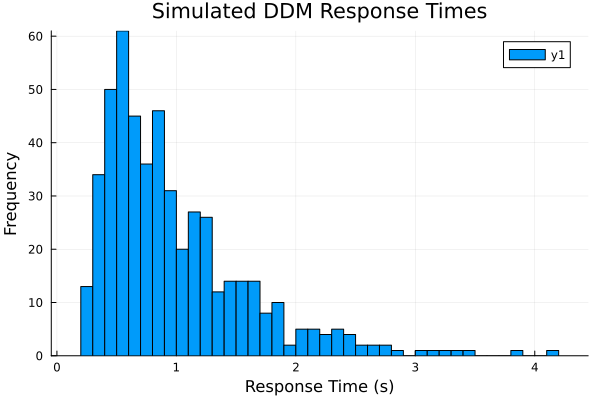

In [3]:
# quickly plot the results so confirm it looks like a DDM!
rts = [res.rt for res in ddm_results]
histogram(rts, bins=50, title="Simulated DDM Response Times", xlabel="Response Time (s)", ylabel="Frequency")

In [4]:
# we can fit the model as follows
ddm = DriftDiffusionModel(;τ=0.05) #
fit!(ddm, ddm_results) 

println("Fitted DDM parameters:" )
println("Boundary Height: ", ddm.B)
println("Drift Rate: ", ddm.v)
println("Initial Starting Point: ", ddm.a₀)
println("Non-decision time: ", ddm.τ)

Fitted DDM parameters:
Boundary Height: 1.9790496645554834
Drift Rate: 0.7692015693226482
Initial Starting Point: 0.6238452207524212
Non-decision time: 0.2144986021784105


In [5]:
# now we can look at what if we have data from an experment, we can load it and fit the DDM to it
# assume you have some data like follows

rts = [0.45, 0.52, 0.39, 0.61, 0.48, 0.55, 0.50, 0.47, 0.60, 0.53] # response times in seconds
choices = [1, -1, 1, 1, -1, 1, -1, -1, 1, -1] # choices made (1 for right, -1 for left)
stimuli = [1, 1, -1, 1, -1, 1, -1, -1, 1, -1] # stimuli presented (1 for right, -1 for left)

# convert to DDMResult format
exp_results = [DDMResult(rt, choice, stim) for (rt, choice, stim) in zip(rts, choices, stimuli)]

# fit the DDM to "experimental data"
new_ddm = DriftDiffusionModel(;τ=0.1)

fit!(new_ddm, exp_results)
println("Fitted DDM parameters to experimental data:" )
println("Boundary Height: ", new_ddm.B)
println("Drift Rate: ", new_ddm.v)
println("Initial Starting Point: ", new_ddm.a₀)
println("Non-decision time: ", new_ddm.τ)

Fitted DDM parameters to experimental data:
Boundary Height: 0.8166938490882452
Drift Rate: 1.775723976857968
Initial Starting Point: 0.6081246537290286
Non-decision time: 0.37202351313758897


In [6]:
@model function lapseBayesDDM(rts::Vector{Float64},
                              choice::Vector{Int},
                              stimulses::Vector{Int})

    N = length(rts)
    max_rt = maximum(rts)
    
    # priors
    logB  ~ Normal(log(2), 0.5)
    logV  ~ Normal(log(1), 0.5)
    a₀    ~ Beta(2, 2)
    τ_rel ~ Beta(2, 5)
    p_lapse ~ Beta(1, 10)    # lapses rare a priori

    τ = τ_rel * max_rt
    B = exp(logB)
    v = exp(logV)

    for i in eachindex(rts)
        rt  = rts[i]
        ch  = choice[i]
        stim = stimulses[i]

        # DDM log-density for this trial
        ll_ddm = logdensityof(B, v, a₀, τ, rt, ch, stim)

        # Lapse log-density for this trial
        ll_lapse_rt = logpdf(Uniform(0.0, max_rt), rt)

        ch_prop = (ch + 1) / 2
        ll_lapse_choice = logpdf(Bernoulli(0.5), ch_prop)

        ll_lapse = ll_lapse_rt + ll_lapse_choice

        m1 = ll_ddm   + log1p(-p_lapse)   # log(1 - p_lapse) + ll_ddm
        m2 = ll_lapse + log(p_lapse)      # log(p_lapse)     + ll_lapse

        mmax = max(m1, m2)
        @addlogprob! (mmax + log(exp(m1 - mmax) + exp(m2 - mmax)))
    end
end


lapseBayesDDM (generic function with 2 methods)

In [ ]:
model = lapseBayesDDM(rts, choices, stimuli)
chain = sample(model, NUTS(), 1000)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference C:\Users\ryansenne\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
Sampling   1%|█                                         |  ETA: 0:45:45
Sampling   1%|█                                         |  ETA: 0:24:19
Sampling   2%|█                                         |  ETA: 0:15:48
Sampling   2%|█                                         |  ETA: 0:12:03
Sampling   3%|██                                        |  ETA: 0:09:28
Sampling   3%|██                                        |  ETA: 0:07:58
Sampling   4%|██                                        |  ETA: 0:06:43
Sampling   4%|██                                        |  ETA: 0:05:55
Sampling   5%|██                                        |  ETA: 0:05:11
Sampling   5%|███                                       |  ETA: 0:04:41
Sampling   6%|███                                       |  ETA: 0:04:13
Samplin

Chains MCMC chain (1000×19×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 16.7 seconds
Compute duration  = 16.7 seconds
parameters        = logB, logV, a₀, τ_rel, p_lapse
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [40]:
μ_logB    = mean(chain["logB"])
μ_logV    = mean(chain["logV"])
μ_a₀      = mean(chain["a₀"])
μ_τ_rel   = mean(chain["τ_rel"])
μ_p_lapse = mean(chain["p_lapse"])

println("Posterior mean estimates:")
println("Boundary Height (B): ", exp(μ_logB))
println("Drift Rate (v): ", exp(μ_logV))
println("Initial Starting Point (a₀): ", μ_a₀)
println("Non-decision time (τ): ", μ_τ_rel * maximum(rts))
println("Lapse Probability (p_lapse): ", μ_p_lapse)

Posterior mean estimates:
Boundary Height (B): 1.0454367747243791
Drift Rate (v): 1.3937190939129285
Initial Starting Point (a₀): 0.5023112755623262
Non-decision time (τ): 0.3462742652187398
Lapse Probability (p_lapse): 0.09427837053730366
